# Alzheimer prediction based on numerical data 

## Summary

In this Notebook the numerical data which is provided by the OASIS-1 dataset (https://www.oasis-brains.org) will be used as input for different classifiers with the aim to predict Alzheimer's disease. Further, the dataset for ADNI-1 will be used in the second part for the same classifier and the performance compared to the OASIS-1 dataset. In the last section, both datasets will be combined and used to predict Alzheimers. 

**NOTE**: In this notebook we will only predict healthy (= 0) and AD (=1), so it is a binary classification problem. 

### The datasets 

The OASIS-1 dataset consists of 416 subjects, of which 316 were diagnosed as being non-demented (CDR = 0, control group) and 100 with being demented ranging from very mild dementia (0.5), mild dementia (1) to moderate dementia (2). The ADNI-1 dataset contains 831 subjects. 



In [1]:
# Import all the required packages 

# Import all the required packages for data analysis and the EDA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import os
import matplotlib.patches as mpatches
from numpy import isnan
import sys
sys.path.append('../')

#Import packages for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

np.random.seed(42)

In [2]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from tadpole_challenge.config_tp import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

In [3]:
# Load functions to get the dataset and process it 
from preprocessing.getdata import get_csvdata, get_tadpole, drop_tadpole, col_tadpole

### Part 1 - The OASIS dataset 

For extended EDA of this dataset have a look into the OASIS_1_EDA_numeric.

In [4]:
#Import the dataset

df_oasis=get_csvdata(drop_young=False, drop_contradictions=False)
df_oasis.head(10)

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_,label,dataset
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0,1344,0.743,1.306,0.0,0,OASIS
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0,1147,0.810,1.531,0.0,0,OASIS
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,1,1454,0.708,1.207,0.5,1,OASIS
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,0,1588,0.803,1.105,0.0,0,OASIS
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,0,1737,0.848,1.010,0.0,0,OASIS
5,OAS1_0006_MR1,F,24,NaN,NaN,NaN,0,1131,0.862,1.551,0.0,0,OASIS
6,OAS1_0007_MR1,M,21,NaN,NaN,NaN,0,1516,0.830,1.157,0.0,0,OASIS
7,OAS1_0009_MR1,F,20,NaN,NaN,NaN,0,1505,0.843,1.166,0.0,0,OASIS
8,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0,1636,0.689,1.073,0.0,0,OASIS
9,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0,1321,0.827,1.329,0.0,0,OASIS


In [5]:
df_oasis.drop(columns=['dataset', 'CDR_', 'label'], inplace=True, axis=1)

In [6]:
df_oasis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Age     436 non-null    int64  
 3   Educ    235 non-null    float64
 4   SES     216 non-null    float64
 5   MMSE    235 non-null    float64
 6   CDR     436 non-null    int64  
 7   eTIV    436 non-null    int64  
 8   nWBV    436 non-null    float64
 9   ASF     436 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 34.2+ KB


In [7]:
#For the modeling, we do not need the ID column since it does not hold any information for the prediction 
df_oasis.drop(columns=['ID'], inplace=True, axis=1)

#Create dummies for the gender column 

df_oasis=pd.get_dummies(df_oasis, columns=['M/F'], drop_first=False)

In [8]:
# Let us check how many missing values we have 
df_oasis.isnull().sum()

Age        0
Educ     201
SES      220
MMSE     201
CDR        0
eTIV       0
nWBV       0
ASF        0
M/F_F      0
M/F_M      0
dtype: int64

In [9]:
#Perform train-test split 
X= df_oasis.drop('CDR', axis=1)
y=df_oasis['CDR']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [10]:
#There are only missing values in the Education, Socioeconomic and MMSE column 
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [11]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 1.1 SVM

In [12]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='1_oasis_trans_scaled_SVM')
run = mlflow.active_run()

In [13]:
# Define hyperparameter grid for SVM
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='f1', verbose=1)

In [14]:
# Print best parameters 
print('Best Parameters:', gs.best_params_)

Best Parameters: {'C': 100, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


In [15]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [16]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.9480122324159022
The accuracy on the test dataset is 0.8256880733944955


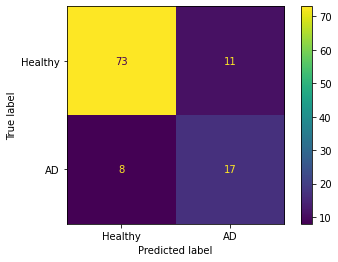

In [17]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [18]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        84
           1       0.61      0.68      0.64        25

    accuracy                           0.83       109
   macro avg       0.75      0.77      0.76       109
weighted avg       0.83      0.83      0.83       109



In [19]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.8256880733944955, 'train-accuracy': 0.9480122324159022}, params={}, tags={'mlflow.runName': '1_oasis_trans_scaled_SVM',
 'mlflow.source.git.commit': '5a2a6d222754c167e22db1bea4d23c17624e1cf1',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/057fd6635ef24a79a8dbf2f54b6305f7/artifacts', end_time=1662386088871, experiment_id='56', lifecycle_stage='active', run_id='057fd6635ef24a79a8dbf2f54b6305f7', run_uuid='057fd6635ef24a79a8dbf2f54b6305f7', start_time=1662386083252, status='FINISHED', user_id='tamarapallien'>>

#### 1.2 ExtraTreeClassifier 

In [20]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='2_oasis_trans_scaled_Xtree')
run = mlflow.active_run()

In [21]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='f1')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.636 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.571 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.750 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.421 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.333 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.750 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.476 total time=   0.0s
[CV 1/5] END

/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/User

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [22]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [23]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 1.0
The accuracy on the test dataset is 0.8623853211009175


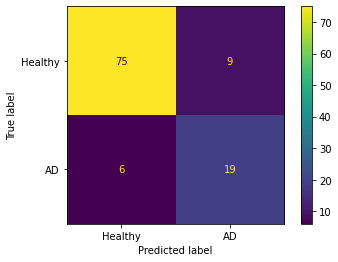

In [24]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [25]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        84
           1       0.68      0.76      0.72        25

    accuracy                           0.86       109
   macro avg       0.80      0.83      0.81       109
weighted avg       0.87      0.86      0.87       109



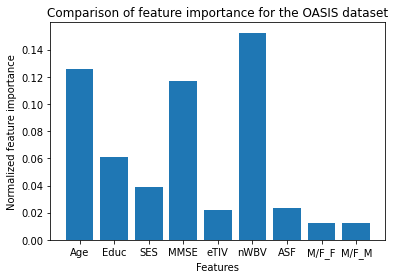

In [26]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized)
plt.xlabel('Features')
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the OASIS dataset')
plt.show()                      

In [27]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.8623853211009175, 'train-accuracy': 1.0}, params={}, tags={'mlflow.runName': '2_oasis_trans_scaled_Xtree',
 'mlflow.source.git.commit': '5a2a6d222754c167e22db1bea4d23c17624e1cf1',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/9df6a90848ea4620887e5242e222a268/artifacts', end_time=1662386112457, experiment_id='56', lifecycle_stage='active', run_id='9df6a90848ea4620887e5242e222a268', run_uuid='9df6a90848ea4620887e5242e222a268', start_time=1662386089060, status='FINISHED', user_id='tamarapallien'>>

### Part 2 - The ADNI dataset 

In [28]:
#Import the dataset

df_adni=get_tadpole()
df_adni.head(10)

/var/folders/v3/9m4l768x37nbr7_d_v6t2fhm0000gn/T/ipykernel_3044/1707069863.py:3: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  df_adni=get_tadpole()


,RID,ID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp,label
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,1.36665,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,22.83,1.08355,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
10,5,011_S_0005,bl,11,ADNI1,ADNI1,2005-09-07,CN,73.7,Male,...,33.43,1.29343,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
20,7,022_S_0007,bl,22,ADNI1,ADNI1,2005-10-06,AD,75.4,Male,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
22,10,011_S_0010,bl,11,ADNI1,ADNI1,2005-11-10,AD,73.9,Female,...,31.26,1.11532,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,1
26,14,022_S_0014,bl,22,ADNI1,ADNI1,2005-11-04,CN,78.5,Female,...,16.68,1.25096,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
31,15,100_S_0015,bl,100,ADNI1,ADNI1,2005-10-18,CN,80.8,Male,...,NaN,NaN,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
34,16,011_S_0016,bl,11,ADNI1,ADNI1,2005-10-13,CN,65.4,Male,...,15.88,1.38702,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
39,21,011_S_0021,bl,11,ADNI1,ADNI1,2005-10-24,CN,72.6,Female,...,NaN,1.37788,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0
43,23,011_S_0023,bl,11,ADNI1,ADNI1,2005-11-08,CN,71.7,Male,...,16.74,1.36097,NaN,NaN,0.0,0.0,0,0,2019-02-14 23:58:27.0,0


In [29]:
# Let us check how many different IDs we have to make sure that we do not have the same person in test and train 
df_adni.nunique()

RID             417
ID              417
VISCODE           1
SITE             56
COLPROT           1
               ... 
Month_bl          1
Month             1
M                 1
update_stamp     10
label             2
Length: 114, dtype: int64

In [30]:
# As the next step we remove all the columns that we do not need for our modeling 
df_adni=drop_tadpole(df_adni)
df_adni.head(2)

,ID,AGE,PTGENDER,PTEDUCAT,APOE4,ABETA,TAU,PTAU,ADAS11,ADAS13,MMSE,RAVLT_immediate,Ventricles,Hippocampus,WholeBrain,Entorhinal,label
0,011_S_0002,74.3,Male,16,0.0,NaN,NaN,NaN,10.67,18.67,28.0,44.0,118233.0,8336.0,1229740.0,4177.0,0
1,011_S_0003,81.3,Male,18,1.0,741.5,239.7,22.83,22.00,31.00,20.0,22.0,84599.0,5319.0,1129830.0,1791.0,1


In [31]:
df_adni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 13134
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               417 non-null    object 
 1   AGE              417 non-null    float64
 2   PTGENDER         417 non-null    object 
 3   PTEDUCAT         417 non-null    int64  
 4   APOE4            417 non-null    float64
 5   ABETA            209 non-null    object 
 6   TAU              209 non-null    object 
 7   PTAU             209 non-null    object 
 8   ADAS11           416 non-null    float64
 9   ADAS13           412 non-null    float64
 10  MMSE             417 non-null    float64
 11  RAVLT_immediate  413 non-null    float64
 12  Ventricles       410 non-null    float64
 13  Hippocampus      345 non-null    float64
 14  WholeBrain       413 non-null    float64
 15  Entorhinal       345 non-null    float64
 16  label            417 non-null    int64  
dtypes: float64(10)

In [32]:
df_adni.isnull().sum()

ID                   0
AGE                  0
PTGENDER             0
PTEDUCAT             0
APOE4                0
ABETA              208
TAU                208
PTAU               208
ADAS11               1
ADAS13               5
MMSE                 0
RAVLT_immediate      4
Ventricles           7
Hippocampus         72
WholeBrain           4
Entorhinal          72
label                0
dtype: int64

In [33]:
#For the modeling, we do not need the ID column since it does not hold any information for the prediction 
df_adni.drop(columns=['ID'], inplace=True, axis=1)

#Create dummies for the gender column 

df_adni=pd.get_dummies(df_adni, columns=['PTGENDER'], drop_first=False)

In [34]:
df_adni=col_tadpole(df_adni)
df_adni

,AGE,PTEDUCAT,APOE4,ABETA,TAU,PTAU,ADAS11,ADAS13,MMSE,RAVLT_immediate,Ventricles,Hippocampus,WholeBrain,Entorhinal,label,PTGENDER_Female,PTGENDER_Male
0,74.3,16,0.0,NaN,NaN,NaN,10.67,18.67,28.0,44.0,118233.0,8336.0,1229740.0,4177.0,0,0,1
1,81.3,18,1.0,741.5,239.7,22.83,22.00,31.00,20.0,22.0,84599.0,5319.0,1129830.0,1791.0,1,0,1
10,73.7,16,0.0,547.3,337.0,33.43,8.67,14.67,29.0,37.0,34062.0,7075.0,1116630.0,4433.0,0,0,1
20,75.4,10,1.0,NaN,NaN,NaN,27.33,40.33,20.0,17.0,25704.0,6729.0,875798.0,2050.0,1,0,1
22,73.9,12,1.0,357.4,329.9,31.26,12.33,24.33,24.0,20.0,26820.0,5485.0,1033540.0,2676.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,72.9,14,0.0,NaN,246.7,20.77,3.67,5.67,29.0,41.0,40569.0,7703.0,1137260.0,4381.0,0,0,1
13124,64.3,16,1.0,314.7,NaN,NaN,42.67,54.67,24.0,10.0,79862.0,NaN,962038.0,NaN,1,0,1
13127,76.7,19,1.0,390.9,NaN,NaN,7.33,11.33,29.0,42.0,41876.0,6986.0,900318.0,4488.0,0,1,0
13133,76.1,16,0.0,529.3,NaN,NaN,5.00,8.00,30.0,50.0,32593.0,5264.0,746249.0,3294.0,0,1,0


In [35]:
df_adni.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 13134
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              417 non-null    float64
 1   PTEDUCAT         417 non-null    int64  
 2   APOE4            417 non-null    float64
 3   ABETA            185 non-null    object 
 4   TAU              205 non-null    object 
 5   PTAU             205 non-null    object 
 6   ADAS11           416 non-null    float64
 7   ADAS13           412 non-null    float64
 8   MMSE             417 non-null    float64
 9   RAVLT_immediate  413 non-null    float64
 10  Ventricles       410 non-null    float64
 11  Hippocampus      345 non-null    float64
 12  WholeBrain       413 non-null    float64
 13  Entorhinal       345 non-null    float64
 14  label            417 non-null    int64  
 15  PTGENDER_Female  417 non-null    uint8  
 16  PTGENDER_Male    417 non-null    uint8  
dtypes: float64(10)

In [36]:
#Perform train-test split 
X= df_adni.drop('label', axis=1)
y=df_adni['label']
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [37]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [38]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 2.1 SVM with Adni dataset 

In [39]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='3_adni_trans_scaled_SVM')
run = mlflow.active_run()

In [40]:
# Define hyperparameter grid for SVM
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]

gs = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto',
                                    'scale'],
                          'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}],
             scoring='f1', verbose=1)

In [41]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [42]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy of the adni on the training set is {acc_train}')
print(f'The accuracy of the adni on the test dataset is {acc_test}')

The accuracy of the adni on the training set is 1.0
The accuracy of the adni on the test dataset is 0.9904761904761905


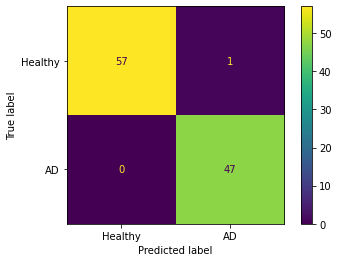

In [43]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [44]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        47

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



In [45]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.9904761904761905, 'train-accuracy': 1.0}, params={}, tags={'mlflow.runName': '3_adni_trans_scaled_SVM',
 'mlflow.source.git.commit': '5a2a6d222754c167e22db1bea4d23c17624e1cf1',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/263a4e0aa65c4422b45a85756b50061d/artifacts', end_time=1662386115033, experiment_id='56', lifecycle_stage='active', run_id='263a4e0aa65c4422b45a85756b50061d', run_uuid='263a4e0aa65c4422b45a85756b50061d', start_time=1662386113157, status='FINISHED', user_id='tamarapallien'>>

#### 2.2 ExtraTreeClassifier on the Adni dataset 

In [46]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='4_adni_trans_scaled_Xtree')
run = mlflow.active_run()

In [47]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='f1')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=1.000 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.963 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.943 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.982 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.982 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.983 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.963 total time=   0.0s
[CV 2/5] END

/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/User

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [48]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [49]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 1.0
The accuracy on the test dataset is 1.0


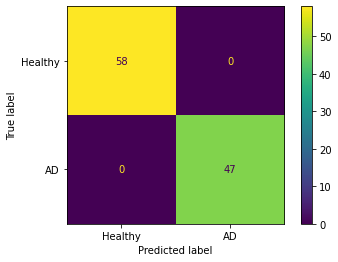

In [50]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [51]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        47

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



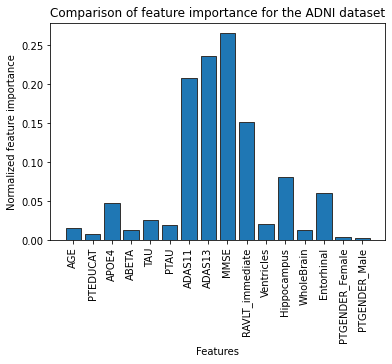

In [52]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

In [53]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 1.0, 'train-accuracy': 1.0}, params={}, tags={'mlflow.runName': '4_adni_trans_scaled_Xtree',
 'mlflow.source.git.commit': '5a2a6d222754c167e22db1bea4d23c17624e1cf1',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/fefa5a180b27484d9855afd9ff0eef27/artifacts', end_time=1662386139152, experiment_id='56', lifecycle_stage='active', run_id='fefa5a180b27484d9855afd9ff0eef27', run_uuid='fefa5a180b27484d9855afd9ff0eef27', start_time=1662386115230, status='FINISHED', user_id='tamarapallien'>>

#### 3. Modeling of the brain measurements only - binary prediction 

We can see in our plot above that especially for the ADNI dataset, there is a huge influence of the cognitive tests on the prediction of Alzheimer's disease. For the next section, we will remove this from the Adni dataset and try the ExtraTree Classifier.

In [54]:
# Load the Adni dataset 
df = pd.read_csv('../modelling/tables/df_ADNI_modelling.csv')

In [55]:
df.head(2)

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,Imputed,label,ID,Sex,Train
0,85.0,39130.0,7068.0,1076350.0,3619.0,0.0,0.0,002_S_0295,M,True
1,76.0,29098.0,6905.0,1052840.0,4133.0,0.0,0.0,002_S_0413,F,False


In [56]:
#Drop the columns with the imputeted and train labels 
df.drop(columns=['Imputed', 'ID', 'Train'], inplace=True, axis=1)

In [57]:
#Create a dummy column for the sex 
df = pd.get_dummies(df)

In [58]:
df.head(2)

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,label,Sex_F,Sex_M
0,85.0,39130.0,7068.0,1076350.0,3619.0,0.0,0,1
1,76.0,29098.0,6905.0,1052840.0,4133.0,0.0,1,0


In [59]:
#Perform train test split 
X=df.drop('label', axis=1)
y=df['label']

X_train,X_test, y_train, y_test=train_test_split(X,y, random_state=42, stratify=y)

In [60]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

#### 3.1 Extra Tree Classifier on the ADNI dataset without the cognitive test results 

In [61]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='6_brain_trans_scaled_Xtree')
run = mlflow.active_run()

In [62]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='f1')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.841 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.835 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.835 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.835 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.835 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.841 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.835 total time=   0.1s
[CV 2/5] END

/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/User

{'criterion': 'gini',
 'max_depth': 32,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'n_estimators': 100}

In [63]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [64]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.86
The accuracy on the test dataset is 0.81


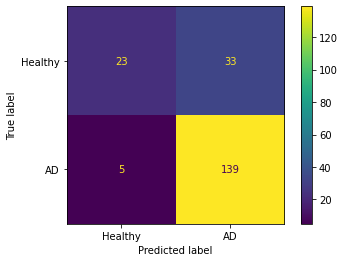

In [65]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned.round())
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy','AD'])
cmd.plot();

In [66]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

         0.0       0.82      0.41      0.55        56
         1.0       0.81      0.97      0.88       144

    accuracy                           0.81       200
   macro avg       0.81      0.69      0.71       200
weighted avg       0.81      0.81      0.79       200



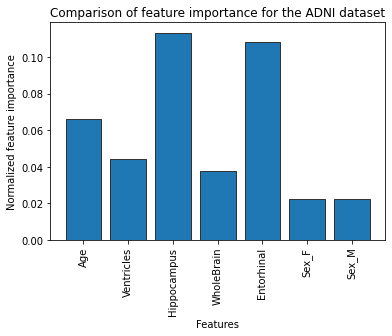

In [67]:
# Computing the importance of each feature
feature_importance = best_model.feature_importances_

# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        best_model.estimators_],
                                        axis = 0)
                        

#Plotting a Bar Graph to compare the models
plt.bar(X.columns, feature_importance_normalized, edgecolor=".2")
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Normalized feature importance')
plt.title('Comparison of feature importance for the ADNI dataset')
plt.show()  

When we pool both dataframes and take out the cognitive tests, the model is performing much worse. Further, we also had many empty rows that we were predicting using the Imputer. Since we do not really now how good this is working, it might also cause some errors. In the last section, we will analyze what kind of errors our model is doing. 

In [68]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.81, 'train-accuracy': 0.86}, params={}, tags={'mlflow.runName': '6_brain_trans_scaled_Xtree',
 'mlflow.source.git.commit': '5a2a6d222754c167e22db1bea4d23c17624e1cf1',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/19c1836073874018ae0c294070dbc990/artifacts', end_time=1662386165462, experiment_id='56', lifecycle_stage='active', run_id='19c1836073874018ae0c294070dbc990', run_uuid='19c1836073874018ae0c294070dbc990', start_time=1662386139542, status='FINISHED', user_id='tamarapallien'>>

#### 4. Error Analysis for the ADNI dataset

For the error analysis we will add the y_pred to our X_test dataframe.  

In [69]:
#Convert X_test into a dataframe 
df_ea = pd.DataFrame(X_test)
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,Sex_F,Sex_M
662,74.0,60763.0,8005.0,1039760.0,3022.0,1,0
682,71.0,16777.0,7246.0,896521.0,5317.0,1,0
168,69.0,35281.0,7192.8,1095870.0,3538.6,0,1
718,86.0,20593.0,7203.0,856263.0,3237.0,1,0
390,74.0,54880.0,5166.0,1108880.0,2709.0,0,1
...,...,...,...,...,...,...,...
517,81.0,33863.0,6422.2,963964.0,3364.2,1,0
379,86.0,25868.0,7975.0,965385.0,3588.0,0,1
702,85.0,60313.0,7240.2,1125500.0,3273.4,0,1
108,76.0,49937.0,7202.0,1181100.0,3965.0,0,1


In [70]:
#Add the test values and the predicted values to the dataframe 

df_ea['y_test'] = y_test.values
df_ea['y_pred'] = y_pred_tuned
df_ea

,Age,Ventricles,Hippocampus,WholeBrain,Entorhinal,Sex_F,Sex_M,y_test,y_pred
662,74.0,60763.0,8005.0,1039760.0,3022.0,1,0,0.0,0.0
682,71.0,16777.0,7246.0,896521.0,5317.0,1,0,0.0,0.0
168,69.0,35281.0,7192.8,1095870.0,3538.6,0,1,1.0,1.0
718,86.0,20593.0,7203.0,856263.0,3237.0,1,0,0.0,0.0
390,74.0,54880.0,5166.0,1108880.0,2709.0,0,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...
517,81.0,33863.0,6422.2,963964.0,3364.2,1,0,1.0,1.0
379,86.0,25868.0,7975.0,965385.0,3588.0,0,1,0.0,1.0
702,85.0,60313.0,7240.2,1125500.0,3273.4,0,1,0.0,1.0
108,76.0,49937.0,7202.0,1181100.0,3965.0,0,1,0.0,1.0


In [71]:
# We write a function to add the classification (TP, TN, FP and FN) to our dataframe 
def classification(row): 
    if (row.y_test == 1) & (row.y_pred == 1): 
        return 'TP'
    if (row.y_test ==1 ) & (row.y_pred == 0): 
        return 'FN'
    if (row.y_test == 0) & (row.y_pred == 1):
        return 'FP'
    if (row.y_test == 0) & (row.y_pred == 0): 
        return 'TN'
 

df_ea['classification']=df_ea.apply(lambda row: classification (row), axis=1)

In [72]:
df_ea['classification'].nunique()

4

In [93]:
# We can have a look on our Top 10 wrongly classified entries 
df_ea_fp = df_ea.query('classification == "FP"').head(10)
print(f'An example of 10 false positive (FP) entries are the following: {df_ea_fp}')

An example of 10 false positive (FP) entries are the following:       Age  Ventricles  Hippocampus  WholeBrain  Entorhinal  Sex_F  Sex_M  \
20   84.0     22169.0       6372.0    851566.0      2962.0      1      0   
183  76.0     96682.0       7506.0   1060960.0      4464.0      0      1   
167  86.0     59014.0       6545.0    963450.0      3195.0      0      1   
322  80.0     27138.0       5702.0   1050900.0      2423.0      1      0   
793  77.0     38937.0       6077.0    993391.0      4514.0      0      1   
568  76.0     32593.0       5264.0    746249.0      3294.0      1      0   
772  73.0     20645.0       6165.0    937019.0      3982.0      1      0   
796  83.0     30573.0       7142.0    903945.0      3059.0      0      1   
484  65.0     21339.0       7713.0   1079510.0      4468.0      0      1   
669  70.0     47656.0       7399.0   1043180.0      4506.0      0      1   

     y_test  y_pred classification  
20      0.0     1.0             FP  
183     0.0     1.0      

In [94]:
df_ea_fp.Age.mean()

77.0

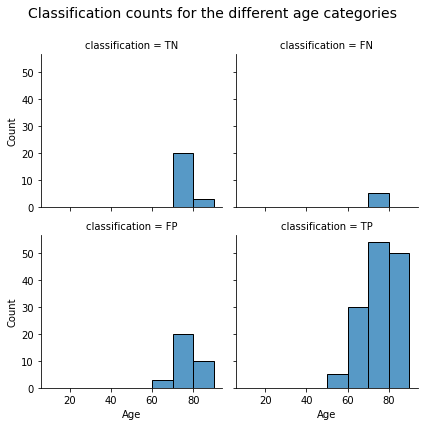

In [74]:
#Plot the classification for the Age 

plot=sns.FacetGrid(data=df_ea, col='classification', col_wrap=2, col_order=['TN', 'FN', 'FP', 'TP'])
plot.map_dataframe(sns.histplot, x='Age', binrange=(10,90), binwidth=10)
plot.fig.subplots_adjust(top=0.87)
plot.fig.suptitle('Classification counts for the different age categories', fontsize=14);

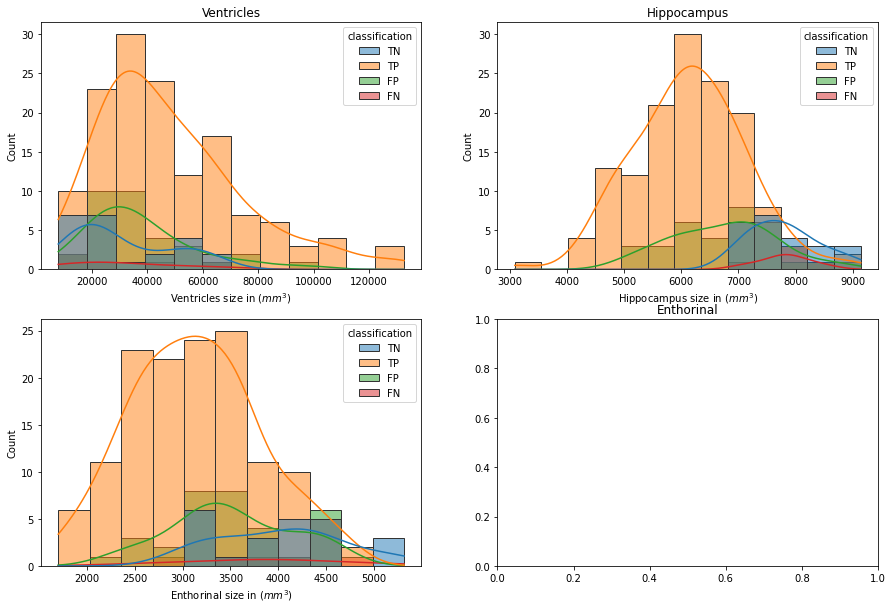

In [75]:
#Plot the classification for the Ventricles, Hippocampus,WholeBrain and	Enthorinal	 

#Create plots with all three different categories 
fig, axes = plt.subplots(2,2, figsize=(15,10))

#Ventricles
sns.histplot(ax=axes[0,0],data=df_ea, x='Ventricles', edgecolor=".2", hue='classification', kde=True).set(xlabel='Ventricles size in ($mm^3$)', ylabel='Count')
axes[0,0].set_title('Ventricles');

#Hippocampus
sns.histplot(ax=axes[0,1],data=df_ea, x='Hippocampus', edgecolor=".2", hue='classification', kde=True).set(xlabel='Hippocampus size in ($mm^3$)', ylabel='Count')
axes[0,1].set_title('Hippocampus');


#Entorhinal
sns.histplot(ax=axes[1,0],data=df_ea, x='Entorhinal', edgecolor=".2", hue='classification', kde=True).set(xlabel='Enthorinal size in ($mm^3$)', ylabel='Count')
axes[1,1].set_title('Enthorinal');

#### 4. Modeling of the brain measurements only - multiclass prediction 

In [76]:
#Load the ADNI dataset with multiple classes 
df_mc=pd.read_csv('../modelling/df_ADNI_multiclass_modelling.csv')

In [77]:
df_mc.head(2)

,Unnamed: 0,ID,Sex,Age,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Imputed
0,0,002_S_0295,M,85,CN,39130.0,7068.0,1076350.0,3619.0,False
1,1,002_S_0413,F,76,CN,29098.0,6905.0,1052840.0,4133.0,False


In [78]:
#Drop the columns with the imputeted and train labels 
df_mc.drop(columns=['Imputed', 'ID', 'Unnamed: 0'], inplace=True, axis=1)

In [79]:
#Create a dummy column for the sex 
df_mc = pd.get_dummies(df_mc, columns=['Sex'])

In [80]:
df_mc.head(2)

,Age,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Sex_F,Sex_M
0,85,CN,39130.0,7068.0,1076350.0,3619.0,0,1
1,76,CN,29098.0,6905.0,1052840.0,4133.0,1,0


In [81]:
df_mc.isnull().sum()

Age              0
DX               0
Ventricles       0
Hippocampus    142
WholeBrain       0
Entorhinal     142
Sex_F            0
Sex_M            0
dtype: int64

In [82]:
#Perform train test split 
X=df_mc.drop('DX', axis=1)
y=df_mc['DX']

X_train,X_test, y_train, y_test=train_test_split(X,y, random_state=42, stratify=y)

In [83]:
#We will use the KNN nearest neighbor imputer to predict those values and fill the empty columns 


#define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(X_train)

# transform X_train und X_test
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [84]:
#As a last step we need to scale our data 
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [85]:
# setting the MLFlow connection and experiment
#mlflow.start_run(run_name='7_brain_trans_scaled_multiclass_Xtree')
#run = mlflow.active_run()

In [95]:
#We analyze the performance of the ExtraTreeClassifier using GridSearch 

param_grid = {'n_estimators': range(50,126,25),
                'criterion': ['gini', 'mse', 'mae'],
                'max_depth': [2, 8, 20, 32, 50],
                'min_samples_split': [2, 4, 6, 20, 30, 60],
                'min_samples_leaf': [1,2]
}

gs = GridSearchCV(ExtraTreesClassifier(), param_grid=param_grid, n_jobs=-1, verbose=3, scoring='accuracy')

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.525 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.525 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=0.500 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.475 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.508 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.533 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.483 total time=   0.0s
[CV 2/5] EN

/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tamarapallien/neuefische/capstone /ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/User

{'criterion': 'gini',
 'max_depth': 32,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [96]:
# Evaluate on test set
best_model = gs.best_estimator_
y_pred_tuned = best_model.predict(X_test_scaled)

In [97]:
# Check out the metrics
acc_train = accuracy_score(y_train, best_model.predict(X_train_scaled))
acc_test = accuracy_score(y_test, y_pred_tuned)
print(f'The accuracy on the training set is {acc_train}')
print(f'The accuracy on the test dataset is {acc_test}')

The accuracy on the training set is 0.835
The accuracy on the test dataset is 0.555


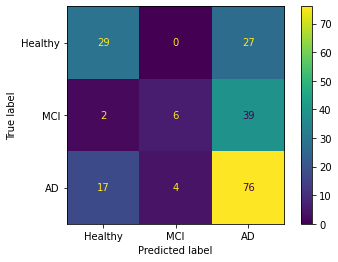

In [98]:
# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred_tuned)
cmd = ConfusionMatrixDisplay(mat, display_labels=['Healthy', 'MCI', 'AD'])
cmd.plot();

In [99]:
#Print out the classification report 
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

          CN       0.60      0.52      0.56        56
    Dementia       0.60      0.13      0.21        47
         MCI       0.54      0.78      0.64        97

    accuracy                           0.56       200
   macro avg       0.58      0.48      0.47       200
weighted avg       0.57      0.56      0.51       200



In [100]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.81, 'train-accuracy': 0.86}, params={}, tags={'mlflow.runName': '6_brain_trans_scaled_Xtree',
 'mlflow.source.git.commit': '5a2a6d222754c167e22db1bea4d23c17624e1cf1',
 'mlflow.source.name': '/Users/tamarapallien/neuefische/capstone '
                       '/ds-capstone-alzheimers-/.venv/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/19c1836073874018ae0c294070dbc990/artifacts', end_time=1662386165462, experiment_id='56', lifecycle_stage='active', run_id='19c1836073874018ae0c294070dbc990', run_uuid='19c1836073874018ae0c294070dbc990', start_time=1662386139542, status='FINISHED', user_id='tamarapallien'>>